In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

import torch
print(torch.__version__)
import torchvision
from torchvision import datasets, transforms
import torch.nn as nn

from IPython.display import clear_output

import helper

0.4.1


# Batch Gradient Descent (with momentum) and Binary Classification

In [2]:
data_dir = '/Users/akshaykulkarni/flowers/train/'
batch_size = 1024
tf = transforms.Compose([transforms.Resize((255, 255)),
                         transforms.ToTensor(),
                        ])

train_dataset = datasets.ImageFolder(data_dir, transform = tf)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = batch_size, shuffle = True, drop_last = True)

data_dir = '/Users/akshaykulkarni/flowers/test/'

test_dataset = datasets.ImageFolder(data_dir, transform = tf)

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = 32, shuffle = True, drop_last = True)

### Loading all the images in the single batch and flattening

In [3]:
images, labels = next(iter(train_loader))
print(images.shape)
images = images.view(-1, images.shape[0]).float()
print(images.shape)
images /= 255
labels = labels.float()
print(labels.shape)

torch.Size([1024, 3, 255, 255])
torch.Size([195075, 1024])
torch.Size([1024])


### Initializing the parameters using no. of nodes and no. of layers

In [19]:
# no. of layers
layers = 3
# no. of nodes in each layer in a list including input and output layers
num_nodes = [images.shape[0], 512, 1]
num_epochs = 5

# initializing weights according to no. of layers and no. of nodes
assert(layers == len(num_nodes))
W = {}
b = {}
Z = {}
dw = {}
db = {}
da = {}
dz = {}
vdw = {}
vdb = {}
# Initialize Weights and Momentum 
for i in range(1, layers):
    var_name = str(i)
    
    # Weight initialization
    W[var_name] = torch.empty(num_nodes[i - 1], num_nodes[i])
    # Xavier initialization of weights
    nn.init.xavier_uniform_(W[var_name], gain=nn.init.calculate_gain('sigmoid'))
    b[var_name] = torch.randn(num_nodes[i], 1)
    
    # Momentum gradient terms initialization
    vdw[var_name] = torch.zeros(W[var_name].shape)
    vdb[var_name] = torch.zeros(b[var_name].shape)
    

### Loss and Activation Functions

In [14]:
def binary_cross_entropy(A, Y):
    loss = (-1 / batch_size) * (torch.matmul(torch.log(A), Y) + torch.matmul(torch.log(1 - A), (1 - Y)))
    return loss

def sigmoid(x):
    return (1 / (1 + torch.exp(-x)))

### Forward Propagation

In [15]:
def forward(x, y):
    out = x
    for i in range(1, layers):
        var_name = str(i)
        out = torch.add(torch.matmul(W[var_name].t(), out), b[var_name])
        Z[var_name] = out
        out = sigmoid(out)
        
    loss = binary_cross_entropy(out, y)
    return loss, out

In [16]:
# loss, out = forward(images, labels)
# print(out)
# print(loss)

### Backward Propagation

In [17]:
def backward(A, Y, X):
    # for last layer
    Y = Y.view(1, Y.shape[0])
    last_layer = str(layers - 1)
    second_last_layer = str(layers - 2)
    dz[last_layer] = A - Y
    dw[last_layer] = (1 / batch_size) * torch.matmul(dz[last_layer], sigmoid(Z[second_last_layer]).t())
    dw[last_layer] = dw[last_layer].t()
    db[last_layer] = (1 / batch_size) * torch.sum(dz[last_layer], 1, keepdim = True)
    da[second_last_layer] = torch.matmul(W[last_layer], dz[last_layer])
    for i in range(layers - 2, 0, -1):
        var_name = str(i)
        prev_name = str(i - 1)
        g_dash_z = sigmoid(Z[var_name]) * (1 - sigmoid(Z[var_name]))
        dz[var_name] = da[var_name] * g_dash_z
        if i == 1:
            dw[var_name] = (1 / batch_size) * torch.matmul(dz[var_name], X.t())
        else:
            dw[var_name] = (1 / batch_size) * torch.matmul(dz[var_name], sigmoid(Z[prev_name]).t())
        dw[var_name] = dw[var_name].t()
        db[var_name] = (1 / batch_size) * torch.sum(dz[var_name], 1, keepdim = True)
        da[prev_name] = torch.matmul(W[var_name], dz[var_name])

### Weights Update

In [18]:
def update_weights(learning_rate, momentum = 0):
    for i in range(1, layers):
        var_name = str(i)
        assert(W[var_name].shape == dw[var_name].shape)
        assert(b[var_name].shape == db[var_name].shape)
        
        # Calculate gradient with momentum
        vdw[var_name] = momentum * vdw[var_name] + (1 - momentum) * dw[var_name]
        vdb[var_name] = momentum * vdb[var_name] + (1 - momentum) * db[var_name]
        
        W[var_name] -= learning_rate * vdw[var_name]
        b[var_name] -= learning_rate * vdb[var_name]

### Training and Validation Loop

In [20]:
train_acc_list = list()
train_loss_list = list()
val_loss_list = list()
val_acc_list = list()
for j in range(num_epochs):
    if torch.cuda.is_available():
        for q in range(1, layers):
            var_name = str(q)
            W[var_name] = W[var_name].cuda()
            b[var_name] = b[var_name].cuda()
        
        images, labels = images.cuda(), labels.cuda()
    
    loss, pred = forward(images, labels)
    train_loss = loss.item()
    train_loss_list.append(train_loss)
    
    backward(pred, labels, images)
    
    pred = (pred >= 0.5)
    pred = pred.view(pred.shape[1])
    mismatch = torch.sum(torch.eq(pred, labels.byte()))
    train_acc = mismatch.item()
    
    update_weights(learning_rate = 0.01, momentum = 0.9)

    train_acc /= (len(train_loader) * batch_size)
    train_acc_list.append(train_acc * 100)
    # print('Training accuracy at epoch ', i, ' = ', acc * 100)
    
    val_loss = 0
    val_acc = 0
    for batch_idx, (val_images, val_labels) in enumerate(test_loader):
        if torch.cuda.is_available():
            val_images = val_images.cuda()
            val_labels = val_labels.cuda()
            for q in range(1, layers):
                var_name = str(q)
                W[var_name] = W[var_name].cuda()
                b[var_name] = b[var_name].cuda()
            
        val_labels = val_labels.float()
        val_images = val_images.view(-1, val_images.shape[0]).float()
        val_images /= 255

        loss, pred = forward(val_images, val_labels)
        val_loss += loss.item()
        pred = (pred >= 0.5)

        pred = pred.view(pred.shape[1])
        mismatch = torch.sum(torch.eq(pred, val_labels.byte()))
        val_acc += mismatch.item()

    val_loss /= len(test_loader)
    val_loss_list.append(val_loss)
    # print('Validation Loss at epoch ', i, ' = ', val_loss)

    val_acc /= (len(test_loader) * 32)
    val_acc_list.append(val_acc * 100)
    
    print(f'Epoch : [{j} / {num_epochs}] | TL : {train_loss} | TA : {train_acc * 100} | VL : {val_loss} | VA : {val_acc * 100}')

Epoch : [0 / 5] | TL : 0.7179510593414307 | TA : 49.12109375 | VL : 0.022806795313954353 | VA : 38.54166666666667
Epoch : [1 / 5] | TL : 0.7032069563865662 | TA : 49.12109375 | VL : 0.02231796644628048 | VA : 37.5
Epoch : [2 / 5] | TL : 0.6971240043640137 | TA : 49.12109375 | VL : 0.022132849941651028 | VA : 32.29166666666667
Epoch : [3 / 5] | TL : 0.6946574449539185 | TA : 49.12109375 | VL : 0.021852990612387657 | VA : 34.375
Epoch : [4 / 5] | TL : 0.6936638355255127 | TA : 49.12109375 | VL : 0.021704763794938724 | VA : 37.5


### Saving Loss and Accuracy lists to memory

In [28]:
import csv

csvfile = "train_loss_list_deepnn.csv"
with open(csvfile, "w") as output:
    writer = csv.writer(output, lineterminator='\n')
    for value in train_loss_list:
        writer.writerow([value])

csvfile = "val_loss_list_deepnn.csv"
with open(csvfile, "w") as output:
    writer = csv.writer(output, lineterminator='\n')
    for value in val_loss_list:
        writer.writerow([value])

csvfile = "train_acc_list_deepnn.csv"
with open(csvfile, "w") as output:
    writer = csv.writer(output, lineterminator='\n')
    for value in train_acc_list:
        writer.writerow([value])

csvfile = "val_acc_list_deepnn.csv"
with open(csvfile, "w") as output:
    writer = csv.writer(output, lineterminator='\n')
    for value in val_acc_list:
        writer.writerow([value])

### Plotting Losses and Accuracies

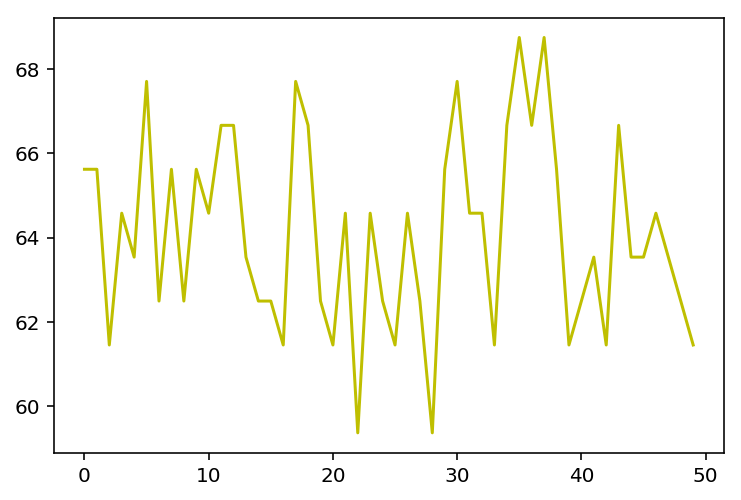

In [35]:
import matplotlib.pyplot as plt
import csv
import numpy as np

with open('train_loss_list_deepnn.csv', 'r') as f:
    reader = csv.reader(f)
    train_loss_list2 = list(reader)

train_loss_list = list()
for i in train_loss_list2:
    for j in i:
        train_loss_list.append(float(j))
        
with open('train_acc_list_deepnn.csv', 'r') as f:
    reader = csv.reader(f)
    train_acc_list2 = list(reader)

train_acc_list = list()
for i in train_acc_list2:
    for j in i:
        train_acc_list.append(float(j))
        
with open('val_loss_list_deepnn.csv', 'r') as f:
    reader = csv.reader(f)
    val_loss_list2 = list(reader)

val_loss_list = list()
for i in val_loss_list2:
    for j in i:
        val_loss_list.append(float(j))
        
with open('val_acc_list_deepnn.csv', 'r') as f:
    reader = csv.reader(f)
    val_acc_list2 = list(reader)

val_acc_list = list()
for i in val_acc_list2:
    for j in i:
        val_acc_list.append(float(j))

iterations = np.arange(0, 50, 1)
# plt.plot(iterations, train_loss_list, 'r')
# plt.plot(iterations, train_acc_list, 'g')
# plt.plot(iterations, val_loss_list, 'b')
plt.plot(iterations, val_acc_list, 'y')
plt.show()